# C14-hepatocyte analysis

default_parameters -> fit

default_limit -> physical

parameters -> physical

In [1]:
import datetime
from IPython.display import display
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

%matplotlib inline

mem = joblib.Memory(location='~/tmp/hepato/', verbose=0)

import logging

%load_ext rpy2.ipython

# logging.basicConfig(filename='c14.log',
#                              filemode='a',
#                              format='%(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)s',
#                             datefmt='%H:%M:%S',
#                              level=logging.DEBUG)
logging.basicConfig(level=logging.WARNING)

R[write to console]: During startup - 
R[write to console]: Warning messages:

R[write to console]: 1: package ‘methods’ was built under R version 3.5.1 

R[write to console]: 2: package ‘datasets’ was built under R version 3.5.1 

R[write to console]: 3: package ‘utils’ was built under R version 3.5.1 

R[write to console]: 4: package ‘grDevices’ was built under R version 3.5.1 

R[write to console]: 5: package ‘graphics’ was built under R version 3.5.1 

R[write to console]: 6: package ‘stats’ was built under R version 3.5.1 



In [2]:
logger = logging.getLogger()
logger.setLevel(logging.WARNING)

In [3]:
# %load_ext autoreload
# %autoreload 2
import c14
import c14.models.liver
import c14.models.minimal

In [4]:
c14.models.liver.global_limit

(0.001, 1000.0)

## Data

In [5]:
data = pd.read_csv('../data/C14data_liver_samples_20191023.csv')
data = data.groupby(['type', 'sample', 'ploidy', 'pathology']).mean().dropna(how='all').reset_index()
data['age'] = data['Dcoll'] - data['Dbirth']
data = data.query('type == "hepatocyte" and pathology != "Y"')
edata = c14.exp_data(data)

## Fit the models

In [6]:
@mem.cache
def fit_model(edata, model, step_size=0.1, optimize_minuit_multistart_kwargs=dict(n=100,processes=8)):
    print(f'Fitting model {model.__name__}')
    result = {'model': model()}
    result['op'] = c14.optimize(model=result['model'],data=edata,step_size=step_size)
    result['vis'] = c14.visualisze(model=result['model'],data=edata,step_size=step_size)
    result['multistart_result'] = result['op'].optimize_minuit_multistart(**optimize_minuit_multistart_kwargs)
    try:
        result['point_estimate'] = result['multistart_result'].sort_values('fval').iloc[0]['values']
        result['cov'] = result['multistart_result'].sort_values('fval').iloc[0]['cov']
    except:
        print(f'Multistart found no valid results for model {model.__name__}')
    try:
        result['errors'] = result['vis'].calc_error(result['point_estimate'], result['cov'], ignore_physics=True)
    except:
        print(f'Could not calculate errors for {model.__name__}')
    return result

In [7]:
def fit_models(edata, models, step_size=0.1, optimize_minuit_multistart_kwargs=dict(n=100,processes=8)):
    results = {model.__name__: fit_model(edata, model, step_size, optimize_minuit_multistart_kwargs)
               for model in models}
    return results

In [8]:
# models = c14.models.liver.models_list + [c14.models.minimal.POP1]
models = [c14.models.liver.R, c14.models.liver.R_k42_free]
models

[c14.models.liver.R, c14.models.liver.R_k42_free]

In [9]:
init_limit = {'r2': (-3, 0), 
              'r2_0': (-3, 0), 
              'r2_100': (-3, 0), 
              'r4': (-3, 0),
              'lambda2': (-3, 0),
              'lambda4': (-3, 0),
              'kappa24': (-3, 0),
              'kappa24_0': (-3, 0),
              'kappa24_100': (-3, 0),
              'kappa42': (-3, 0),
              'delta2': (-3, 0),
              'delta2_0': (-3, 0),
              'delta2_100': (-3, 0),
              'delta4': (-3, 0),
              'f': (1, 3),
              'lambda_': (-3, 0),
              'r2_0': (-3, 0),
              'r2_1': (-3, 0),
              'r2_100': (-3, 0),
              't_step': (np.log10(5), np.log10(70))
             }

In [10]:
np.seterr(all='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [11]:
%%time
results = fit_models(edata, models, step_size=0.1, 
                     optimize_minuit_multistart_kwargs=dict(n=100, 
                                                            processes=12, 
                                                            init_limit=init_limit)
                    )

CPU times: user 285 ms, sys: 2.85 ms, total: 288 ms
Wall time: 296 ms


In [12]:
def summarise(results):
    parameters = pd.concat(
        [result['vis'].get_parameter(result['point_estimate'], 
                                     result['cov'], 
                                     t_eval=[20, 50, 80],
                                     samples=1000,
                                    ignore_physics=True)
         .assign(model = name).reset_index() for name, result in results.items()
        ], ignore_index=True)

    parameters['point_estimate'] = parameters['point_estimate'].astype(float)
    parameters['lower'] = parameters['lower'].astype(float)
    parameters['upper'] = parameters['upper'].astype(float).replace(np.inf, 1e99)
    parameters['parameter'] = parameters['parameter'].astype(str)
    parameters['time'] = parameters['time'].astype(str)

    parameters['ymin'] = parameters['point_estimate'] - parameters['lower']
    parameters['ymax'] = parameters['upper'] - parameters['point_estimate']
    return parameters

In [13]:
parameters = summarise(results)
# parameters_young = summarise(results_young)
# parameters_old = summarise(results_old)

In [14]:
parameters[parameters['lower'] > parameters['point_estimate']]

,time,parameter,point_estimate,lower,upper,model,ymin,ymax


In [15]:
parameters[(parameters['upper'] < parameters['point_estimate'])]

,time,parameter,point_estimate,lower,upper,model,ymin,ymax


## Parameter Values

### Summarized

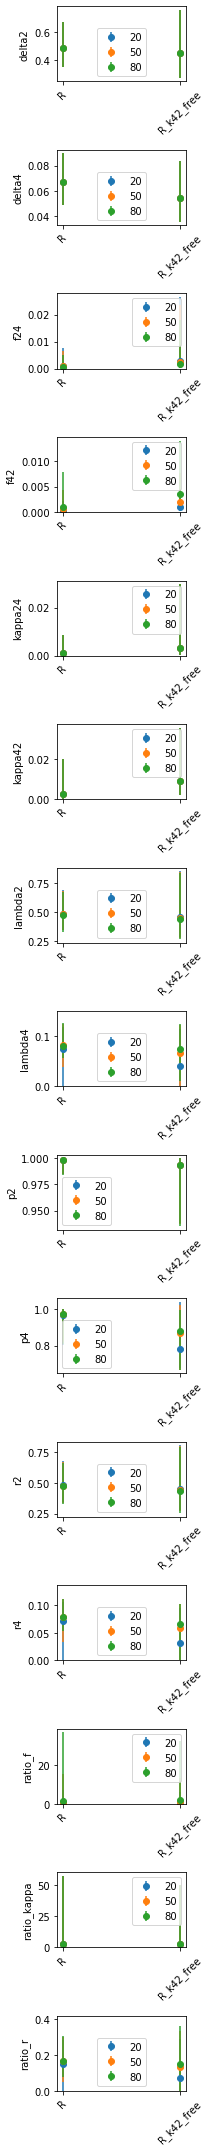

In [36]:
p_names = parameters['parameter'].unique()
# paras = [parameters, parameters_young, parameters_old]

fig, axs = plt.subplots(len(p_names), 1, figsize=(3, 30))



ylimits = {'delta2': (0, 1),
           'p2': (0.5, 1.1),
           'p4': (0.5, 1.1),
           'kappa24': (0, 0.5),
           'kappa42': (0, 1.15),
          'ratio_kappa': (0, 10)}

for parameter, ax in zip(p_names, axs):
    data = parameters[parameters['parameter'] == parameter]
    for time, time_data in data.groupby('time'):
        ax.errorbar('model', 'point_estimate', time_data[['ymin', 'ymax']].T.abs().values,
                    data=time_data, marker='o', ls='None', label=time)
        ax.legend()
        ax.set_ylabel(parameter)
#     try:
#         ax.set_ylim(ylimits[parameter])
#     except:
    ylim = ax.get_ylim()
    ax.set_ylim(max(ylim[0], 0), ylim[1])
    ax.tick_params(axis='x', labelrotation=45)

plt.tight_layout()
plt.show()

### Detailed

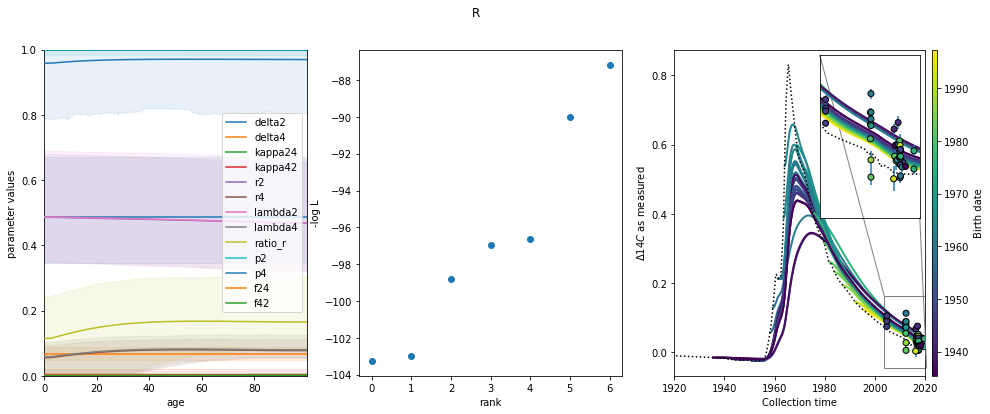

point_estimate        lower       upper
time parameter                                          
0    delta2            0.486868     0.347328    0.669529
     delta4           0.0669913    0.0491734   0.0896802
     f24            0.000921598  9.48791e-05  0.00778454
     f42            0.000197603  1.95544e-05  0.00163754
     kappa24         0.00100358  0.000103319  0.00847701
     kappa42         0.00241902  0.000239382   0.0200464
     lambda2           0.487061     0.350126    0.690147
     lambda4          0.0582523    -0.087075    0.104055
     p2                 0.99794     0.984461    0.999776
     p4                0.958473     0.787847     1.00261
     r2                0.486057     0.348143    0.679727
     r4               0.0558333   -0.0990203   0.0940131
     ratio_f           0.214414   0.00956263     5.11885
     ratio_kappa         2.4104     0.107501     57.5452
     ratio_r            0.11487    -0.170923    0.244755
50   delta2            0.486868     0.347328    0.669529
     delta4           0.0669913    0.0491734   0.0896802
     f24            0.000790468  8.13792e-05  0.00667692
     f42            0.000513677  5.08325e-05  0.00425684
     kappa24         0.00100358  0.000103319  0.00847701
     kappa42         0.00241902  0.000239382   0.0200464
     lambda2           0.478681     0.339764    0.681323
     lambda4          0.0820807    0.0394055    0.124037
     p2                0.997903     0.984231    0.999777
     p4                0.970529      0.81974    0.999308
     r2                0.477678     0.335034    0.668547
     r4               0.0796617    0.0330938      0.1119
     ratio_f           0.649839    0.0289821      15.514
     ratio_kappa         2.4104     0.107501     57.5452
     ratio_r           0.166769    0.0500781    0.301957
80   delta2            0.486868     0.347328    0.669529
     delta4           0.0669913    0.0491734   0.0896802
     f24            0.000611724  6.29774e-05  0.00516711
     f42            0.000944524  9.34682e-05  0.00782726
     kappa24         0.00100358  0.000103319  0.00847701
     kappa42         0.00241902  0.000239382   0.0200464
     lambda2           0.472088     0.326623    0.669696
     lambda4          0.0805894    0.0564898    0.125951
     p2                0.997874     0.983528    0.999776
     p4                0.969983     0.809299    0.998384
     r2                0.471085     0.324598    0.659399
     r4               0.0781704    0.0538507    0.111633
     ratio_f            1.54404    0.0688624     36.8618
     ratio_kappa         2.4104     0.107501     57.5452
     ratio_r           0.165937    0.0788002    0.305416
100  delta2            0.486868     0.347328    0.669529
     delta4           0.0669913    0.0491734   0.0896802
     f24            0.000543619  5.59659e-05  0.00459184
     f42             0.00110868  0.000109713  0.00918765
     kappa24         0.00100358  0.000103319  0.00847701
     kappa42         0.00241902  0.000239382   0.0200464
     lambda2           0.469474     0.322208    0.666099
     lambda4          0.0797125    0.0571834    0.126103
     p2                0.997862     0.983492    0.999779
     p4                0.969653     0.805131    0.998046
     r2                 0.46847     0.320166    0.657161
     r4               0.0772935    0.0544633    0.112054
     ratio_f            2.03945    0.0909574     48.6892
     ratio_kappa         2.4104     0.107501     57.5452
     ratio_r           0.164991    0.0840718    0.304234

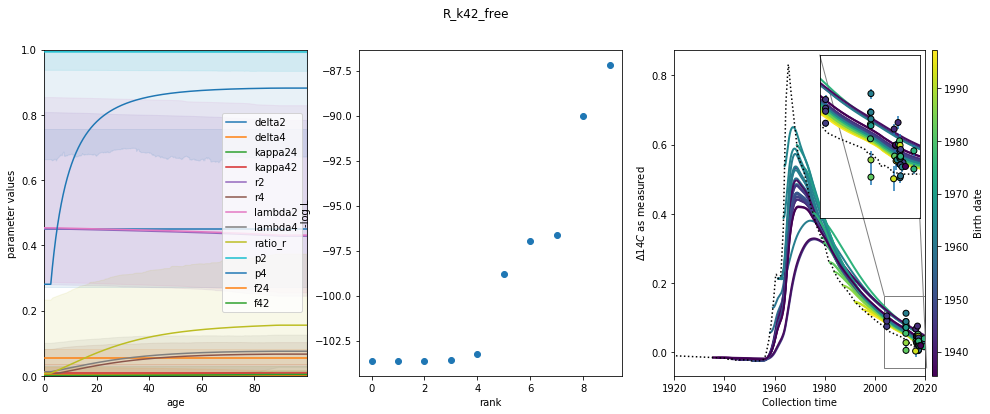

point_estimate        lower       upper
time parameter                                          
0    delta2            0.450037     0.271888    0.757233
     delta4            0.054579    0.0359685   0.0833101
     f24             0.00281744   0.00025623   0.0273302
     f42            0.000725471  0.000182938  0.00293508
     kappa24         0.00306806  0.000279023   0.0297613
     kappa42          0.0088811    0.0022395   0.0359307
     lambda2           0.453784     0.288044    0.854574
     lambda4           0.012347    -0.546595     0.10096
     p2                0.993239     0.938215    0.999391
     p4                0.280706     0.664073     1.05687
     r2                0.450716      0.28064    0.808548
     r4              0.00346586    -0.562784   0.0825079
     ratio_f           0.257493    0.0214067     4.47039
     ratio_kappa        2.89469     0.240651     50.2554
     ratio_r         0.00768967     -1.17395    0.232205
50   delta2            0.450037     0.271888    0.757233
     delta4            0.054579    0.0359685   0.0833101
     f24             0.00241656  0.000219773   0.0234415
     f42             0.00188589  0.000475555  0.00762985
     kappa24         0.00306806  0.000279023   0.0297613
     kappa42          0.0088811    0.0022395   0.0359307
     lambda2           0.444237     0.276492    0.845287
     lambda4          0.0672772    -0.102218    0.123489
     p2                0.993094     0.936892     0.99938
     p4                0.867992     0.668344     1.02283
     r2                0.441169     0.269851    0.798306
     r4               0.0583961     -0.11082    0.102479
     ratio_f           0.780403    0.0648789     13.5487
     ratio_kappa        2.89469     0.240651     50.2554
     ratio_r           0.132367    -0.234371    0.335382
80   delta2            0.450037     0.271888    0.757233
     delta4            0.054579    0.0359685   0.0833101
     f24             0.00187012  0.000170077   0.0181408
     f42             0.00346768  0.000874426   0.0140294
     kappa24         0.00306806  0.000279023   0.0297613
     kappa42          0.0088811    0.0022395   0.0359307
     lambda2           0.435247      0.26254    0.833295
     lambda4          0.0746555   0.00956479    0.124375
     p2                0.992951      0.93501    0.999378
     p4                0.881039     0.669913    0.995705
     r2                0.432179     0.252361    0.788425
     r4               0.0657744   -0.0036047     0.10297
     ratio_f            1.85426     0.154154     32.1922
     ratio_kappa        2.89469     0.240651     50.2554
     ratio_r           0.152192    -0.011112    0.361667
100  delta2            0.450037     0.271888    0.757233
     delta4            0.054579    0.0359685   0.0833101
     f24             0.00166191  0.000151141   0.0161211
     f42             0.00407037    0.0010264   0.0164677
     kappa24         0.00306806  0.000279023   0.0297613
     kappa42          0.0088811    0.0022395   0.0359307
     lambda2           0.431304     0.256052     0.82971
     lambda4          0.0753444    0.0274582    0.126114
     p2                0.992887     0.934962    0.999373
     p4                0.882127     0.672278    0.991854
     r2                0.428236     0.245526    0.784442
     r4               0.0664633    0.0143198    0.103392
     ratio_f            2.44921     0.203616     42.5213
     ratio_kappa        2.89469     0.240651     50.2554
     ratio_r           0.155202    0.0157622    0.372732

In [17]:
for name, result in results.items():
    if name not in ['']:
        no_plot = ['ratio_kappa', 'ratio_f']
        fig, axs = plt.subplots(1, 3, figsize=(16,6))
        fig.suptitle(name)
        result['vis'].plot_parameter(result['point_estimate'], result['errors'],
                                         no_plot=no_plot, axis=axs[0])
#         result['vis'].plot_parameter(result['point_estimate'], 
#                                          no_plot=no_plot, axis=axs[0])

        axs[0].legend()
        axs[0].set_ylabel('parameter values')
        axs[0].set_ylim(0, 1)

        fval = result['multistart_result']['fval']
        axs[1].scatter(np.arange(len(fval)), fval.values)
        axs[1].set_xlabel('rank')
        axs[1].set_ylabel('-log L')
    #         axs[1].set_xlim(0, 100)
        
        _ = result['vis'].odeint()
        result['vis'].plot_simdata( axis=axs[2], cmap=plt.cm.viridis)
        axs[2].set_xlim(1920, 2020)

        plt.show()

        try:
            display(result['vis'].get_parameter(result['point_estimate'], result['cov'], t_eval=[0, 50, 80, 100], ignore_physics=True
                                               ))
        except:
            pass

## Export

In [18]:
# model = 'A'

# time = np.linspace(0, 100, 101)
# df = pd.DataFrame(results[model]['model'].get_implicit_parameters(time))[['r2', 'kappa24', 'ratio_r', 'p']]
# # df.columns=['r2', 'r4', 'kappa24', 'kappa42', 'ratio_r']
# df['r4'] = results[model]['model'].r4
# df['kappa42'] = results[model]['model'].kappa42
# df['delta2'] = results[model]['model'].delta2
# df['delta4'] = results[model]['model'].delta4
# df['age'] = time
# df['ploidy'] = c14.models.liver.A().ploidy(df['age'])
# df.head()

# result = results[model]
# df = result['vis'].get_parameter(result['point_estimate'], result['cov'], t_eval=time).unstack().reset_index()

# df = df[['time', 'point_estimate']]

# df.to_excel('../../../results/parameters_A.xlsx')

## Model selection

In [19]:
_ = results.pop('POP1', None)

In [20]:
model_selection_results = pd.DataFrame(
    pd.Series(
        {name: result['op'].calc_aicc(result['point_estimate'])
         for name, result in results.items()}, name='cAIC'))
model_selection_results['loglike'] = [result['op'].loglike_dict(result['point_estimate']) for name, result in results.items()]
model_selection_results['nparas'] = [result['model'].nparas for name, result in results.items()] 
model_selection_results['nparas'] += 1
model_selection_results = pd.DataFrame(model_selection_results)
model_selection_results['delta'] = model_selection_results['cAIC'] - model_selection_results['cAIC'].min() 
model_selection_results['w'] = np.exp(-0.5*model_selection_results['delta']) / np.exp(-0.5*model_selection_results['delta']).sum()
model_selection_results['ER'] = model_selection_results['w'].max() / model_selection_results['w']
model_selection_results.sort_values('cAIC')

,cAIC,loglike,nparas,delta,w,ER
R_k42_free,-195.528876,103.621581,5,0.000000,0.592652,1.000000
R,-194.778993,103.246640,5,0.749883,0.407348,1.454906


In [21]:
# parameters = parameters.merge(model_selection_results, left_on='model', right_index=True)

In [22]:
# parameters['log10_point_estimate'] = np.log10(parameters['point_estimate'])
# parameters['log10_lower'] = np.log10(parameters['lower'])
# parameters['log10_upper'] = np.log10(parameters['upper'])
# parameters.head()

# parameters['log10_error_lower'] = parameters['log10_point_estimate'] - parameters['log10_lower']
# parameters['log10_error_upper'] = -parameters['log10_point_estimate'] + parameters['log10_upper']

# parameters['log10_error'] = parameters[['log10_error_lower', 'log10_error_upper']].mean(axis='columns')

# parameters.head()

# def parameter_average(data):
#     parameter = data['parameter'].iloc[0]
#     log10_mean = np.average(data['log10_point_estimate'], weights=data['w'])
#     log10_error = np.average(
#         np.sqrt(data['log10_error']**2 + (data['log10_point_estimate'] - log10_mean)**2),
#         weights=data['w'])
#     point_estimate = 10**log10_mean
#     lower = 10**(log10_mean-log10_error)
#     upper = 10**(log10_mean+log10_error)
#     return pd.Series({
#         'point_estimate': point_estimate,
#         'lower': lower,
#         'upper': upper,
#         'model': 'average',
#         'ymin': point_estimate - lower,
#         'ymax': point_estimate + upper,
#         'log10_point_estimate': log10_mean,
#         'log10_error': log10_error
#     })

# rates = ["r2", "r4", "delta2", "delta4", "kappa24", "kappa42", "lambda2", "lambda4"]

# averaged_parameters = (parameters
#                        .query('parameter in @rates')
#                        .groupby(['time', 'parameter'])
#                        .apply(parameter_average)
#                        .reset_index()
#                         )

In [23]:
# parameters = pd.concat([parameters, averaged_parameters], axis='rows', sort=False)

In [24]:
# p_names = parameters['parameter'].unique()
# paras = 3*[parameters]
# fig, axss = plt.subplots(len(p_names), len(paras), figsize=(9, 30))



# ylimits = {'delta2': (0, 2),
#            'delta4': (0, 1),
#            'lambda2': (0, 2),
#            'r2': (0, 2),
#            'p2': (0.5, 1.1),
#            'p4': (0.5, 1.1),
#            'kappa24': (0, 0.2),
#           'ratio_kappa': (0, 10)}

# for parameter, axs in zip(p_names, axss):
#     for para, ax in zip(paras, axs):
#         data = para[para['parameter'] == parameter]
#         for time, time_data in data.groupby('time'):
#             ax.errorbar('model', 'point_estimate', time_data[['ymin', 'ymax']].T.abs().values,
#                         data=time_data, marker='o', ls='None', label=time)
#             ax.legend()
#             ax.set_ylabel(parameter)
#         try:
#             ax.set_ylim(ylimits[parameter])
#         except:
#             ax.set_ylim(0, 1)
#         ax.tick_params(axis='x', labelrotation=45)

# plt.tight_layout()
# plt.show()